In [11]:
output_path = './outputs/graphs/'
results_path = 'outputs/goemotions/'

In [12]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import graph_code.graphing_utils as plotting
from copy import deepcopy

In [13]:
colwidth = 4.22716535
pagewidth = 8.7598425

In [14]:
results_dict = {}

for file in [
    f 
    for f in os.listdir(results_path)
    if f.endswith("json")
]:
    with open(results_path + file) as f:
        results_temp = json.load(f)
    results_dict[file] = results_temp

In [15]:
results_idpa = {
    ds : {
        ctype : {
            run: {
                'idpa': results_dict['results_idpa.json'][ds][ctype][run]
            } for run in results_dict['results_idpa.json'][ds][ctype]
        } for ctype in results_dict['results_idpa.json'][ds]
    } for ds in results_dict['results_idpa.json']
}

results_cot = {
    ds : {
        ctype : {
            run: {
                'cot': results_dict['results_cot.json'][ds][ctype][run]
            } for run in results_dict['results_cot.json'][ds][ctype]
        } for ctype in results_dict['results_cot.json'][ds]
    } for ds in results_dict['results_cot.json']
}

results_cdr = {
    ds : {
        ctype : {
            run: {
                'cdr': results_dict['results_cdr.json'][ds][ctype][run]
            } for run in results_dict['results_cdr.json'][ds][ctype]
        } for ctype in results_dict['results_cdr.json'][ds]
    } for ds in results_dict['results_cdr.json']
}

results_nls = {
    ds : {
        ctype : {
            run: {
                'nls': results_dict['results_nls.json'][ds][ctype][run]
            } for run in results_dict['results_nls.json'][ds][ctype]
        } for ctype in results_dict['results_nls.json'][ds]
    } for ds in results_dict['results_nls.json']
}


results_dict['results_idpa.json'] = results_idpa
results_dict['results_cot.json'] = results_cot
results_dict['results_cdr.json'] = results_cdr
results_dict['results_nls.json'] = results_nls


In [16]:
def combine_results_dict(results_dict_in, results_out):
    
    # results dict in should be of form: 
    # {dataset: {corruption_type: {run: {method: {epoch: metrics}}}}}

    for dataset in results_dict_in:
        if dataset not in results_out:
            results_out[dataset] = {}

        for corruption_type in results_dict_in[dataset]:
            if corruption_type not in results_out[dataset]:
                results_out[dataset][corruption_type] = {}

            for run in results_dict_in[dataset][corruption_type]:
                if run not in results_out[dataset][corruption_type]:
                    results_out[dataset][corruption_type][run] = {}

                for method in results_dict_in[dataset][corruption_type][run]:

                    results_out[dataset][corruption_type][run][method] = [
                        dict(epoch=int(epoch), **metrics) 
                        for epoch, metrics in results_dict_in[
                            dataset
                        ][corruption_type][run][method].items() 
                        if epoch != 'corrupt_sources'
                    ]

In [17]:
combined_results = {}

for result in results_dict:
    combine_results_dict(results_dict[result], combined_results)

In [18]:
combined_results_df = []

for dataset in combined_results:
    for corruption_type in combined_results[dataset]:
        for run in combined_results[dataset][corruption_type]:
            for method in combined_results[dataset][corruption_type][run]:
                combined_results_df.append(
                    pd.json_normalize(
                        combined_results[dataset][corruption_type][run][method]
                    )
                    .assign(
                        dataset=dataset,
                        corruption_type=corruption_type,
                        run=run,
                        method=method
                    )
                    .assign(epoch=lambda x: x['epoch']+1)
                )

combined_results_df = pd.concat(combined_results_df)
combined_results_df = (
    combined_results_df
    .replace({"method": {"true": True, "false": False}})
    .astype(
        {
            "run": "int64",
        }
    )
)

In [19]:
combined_results_df = combined_results_df.melt(
    id_vars=['dataset', 'corruption_type', 'run', 'method', 'epoch'],
    var_name='metric',
    value_name='value'
)

In [22]:
def bold_max_value_latex(x, model_names):
    x = x.copy()
    len_cols = x.shape[0]
    n_models = len(model_names)
    idx_bold = (
        x
        [-n_models:]
        .str.replace(" ", "")
        .str.split("±")
        .str[0]
        .astype(float)
        .argmax()
    )
    max_val = x.iloc[idx_bold+len_cols-n_models]
    max_val, max_std = map(float, max_val.split("±"))

    for i in range(len_cols-n_models, len_cols):
        val = x.iloc[i]
        val, std = map(float, val.split("±"))
        if val >= max_val - max_std and val <= max_val + max_std:
            x.iloc[i] = '\\textbf{' + x.iloc[i] + '}'
    
    return x


corruption_types = {
    "original": "Original Data",
    "random_label": "Random Label",
}

corruption_order = [
    "original",
    "random_label",
]


model_order = [
    'Co-teaching',
    'IDPA',
    'CDR',
    "Label Smoothing",
    'Standard',
    'LAP (Ours)',
]

combined_results_final_df = (
    combined_results_df
    .loc[lambda df: df.metric == 'test_top5acc']
    .groupby(["method", 'corruption_type', "run"])
    [['value']]
    .max()
    .assign(value = lambda x: x['value']*100)
    .reset_index()
    .groupby(['corruption_type', "method"])
    ['value']
    .agg(['mean', 'std'])
    .assign(
        mean_std = lambda x: 
            np.round(x['mean'], 2).astype(str) 
            + " ± "
            + np.round(x['std'], 2).astype(str),
    )
    ['mean_std']
    .to_frame()
    .reset_index()
    .rename(columns={
        "method": "LAP", 
        'corruption_type': "Noise Type", 
        "mean_std": "Top-5 Accuracy"
    })
    .replace(
        {
            "LAP": {
                False: "Standard",
                True: "LAP (Ours)",
                'cot': 'Co-teaching',
                'idpa': 'IDPA',
                'cdr': 'CDR',
                'nls': 'Label Smoothing',
            }
        }
    )
    .pivot(
        index="Noise Type",
        columns="LAP",
        values="Top-5 Accuracy"
    )
    .reset_index()
    [[
        'Noise Type',  'Standard', 'IDPA', 'Co-teaching', 'CDR', 'Label Smoothing', 'LAP (Ours)',  
    ]]
    .loc[
        lambda x: x['Noise Type'].isin(corruption_order)
    ]
    .sort_values(
        "Noise Type", key=lambda x: x.map(corruption_order.index)
    )
    .replace(
        {
            "Noise Type": corruption_types
        }
    )
    # makes bold with latex:
    .apply(
        bold_max_value_latex,
        model_names = model_order,
        axis=1
    )
)

combined_results_final_df

LAP,Noise Type,Standard,IDPA,Co-teaching,CDR,Label Smoothing,LAP (Ours)
0,Original Data,\textbf{80.43 ± 0.05},79.66 ± 0.21,79.7 ± 0.31,\textbf{80.37 ± 0.1},\textbf{80.35 ± 0.07},\textbf{80.44 ± 0.15}
1,Random Label,76.96 ± 0.58,76.05 ± 0.84,77.05 ± 0.7,76.05 ± 0.31,76.02 ± 0.57,\textbf{78.74 ± 0.41}


In [23]:
print(
    combined_results_final_df.to_latex(index=False)
)

\begin{tabular}{lllllll}
\toprule
Noise Type & Standard & IDPA & Co-teaching & CDR & Label Smoothing & LAP (Ours) \\
\midrule
Original Data & \textbf{80.43 ± 0.05} & 79.66 ± 0.21 & 79.7 ± 0.31 & \textbf{80.37 ± 0.1} & \textbf{80.35 ± 0.07} & \textbf{80.44 ± 0.15} \\
Random Label & 76.96 ± 0.58 & 76.05 ± 0.84 & 77.05 ± 0.7 & 76.05 ± 0.31 & 76.02 ± 0.57 & \textbf{78.74 ± 0.41} \\
\bottomrule
\end{tabular}



In [ ]:
import torch
from torchvision.datasets.utils import download_url
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


class GoEmotions(torch.utils.data.Dataset):
    def __init__(
        self,
        root="./data/",
        max_length=512,
    ):
        self.root = root
        self.max_length = max_length

        if not os.path.exists(os.path.join(self.root, "goemotions")):
            os.makedirs(os.path.join(self.root, "goemotions"))

        files_exist = np.all(
            [
                os.path.exists(
                    os.path.join(self.root, "goemotions", f"goemotions_{i}.csv")
                )
                for i in range(1, 4)
            ]
        )

        if not files_exist:
            download_url(
                "https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv",
                os.path.join(self.root, "goemotions"),
            )
            download_url(
                "https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv",
                os.path.join(self.root, "goemotions"),
            )
            download_url(
                "https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv",
                os.path.join(self.root, "goemotions"),
            )

        self.data = pd.concat(
            [
                pd.read_csv(
                    os.path.join(self.root, "goemotions", f"goemotions_{i}.csv")
                )
                for i in range(1, 4)
            ]
        )

        self.y_unique = [
            "admiration",
            "amusement",
            "anger",
            "annoyance",
            "approval",
            "caring",
            "confusion",
            "curiosity",
            "desire",
            "disappointment",
            "disapproval",
            "disgust",
            "embarrassment",
            "excitement",
            "fear",
            "gratitude",
            "grief",
            "joy",
            "love",
            "nervousness",
            "optimism",
            "pride",
            "realization",
            "relief",
            "remorse",
            "sadness",
            "surprise",
            "neutral",
        ]

        X = self.data["text"].values
        y = self.data[self.y_unique].values
        sources = self.data["rater_id"].values

        rows_with_no_labels = y.sum(axis=1) == 0
        X = X[~rows_with_no_labels]
        y = y[~rows_with_no_labels]
        sources = sources[~rows_with_no_labels]

        rows_with_too_many_labels = y.sum(axis=1) > 1
        X = X[~rows_with_too_many_labels]
        y = y[~rows_with_too_many_labels]
        sources = sources[~rows_with_too_many_labels]

        y = np.argmax(y, axis=1)

        self.inputs = X
        self.targets = y
        self.sources = sources

        tokeniser = get_tokenizer("basic_english")
        vocab = build_vocab_from_iterator(
            map(tokeniser, X),
            specials=["<pad>", "<unk>"],
        )
        vocab.set_default_index(vocab["<unk>"])

        self.tokeniser = tokeniser
        self.vocab = vocab

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        text = self.inputs[idx]

        text_tensor = (
            torch.zeros(self.max_length, dtype=torch.long) * self.vocab["<pad>"]
        )
        text_split = self.tokeniser(text)[: self.max_length]
        text_tokens = [
            torch.tensor(self.vocab(self.tokeniser(item)), dtype=torch.long)
            for item in text_split
        ]
        text_tensor_raw = torch.cat(tuple(filter(lambda t: t.numel() > 0, text_tokens)))
        text_tensor[: text_tensor_raw.size(0)] = text_tensor_raw

        label = self.targets[idx]
        source = self.sources[idx]

        return (
            text_tensor,
            label,
            source,
        )

In [13]:
dataset = GoEmotions(
    root="./data/",
    max_length=128,
)

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset,
    [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))],
    generator=torch.Generator().manual_seed(42),
)
train_idx = train_dataset.indices
test_idx = test_dataset.indices

100%|██████████| 14174600/14174600 [00:02<00:00, 4967311.29it/s]


100%|██████████| 14173154/14173154 [00:03<00:00, 4179269.64it/s]


100%|██████████| 14395164/14395164 [00:02<00:00, 4970265.67it/s]


In [14]:
dataset.sources[train_dataset.indices]
dataset.targets[train_dataset.indices]

array([27,  3, 15, ...,  4, 27,  2], dtype=int64)

In [15]:
np.unique(dataset.sources[train_dataset.indices], return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81],
       dtype=int64),
 array([  30,  912, 3942, 2203, 7479, 2211, 3147,  982, 1509,  301,  729,
        1499, 1944,  133,  451, 2582, 2302,   98, 2194, 1339, 2882, 2072,
        1268, 3136, 4121,  256, 3500, 3623,  621,  193, 1021,  143,  368,
        3379, 1372, 3156, 1753, 3647, 1085, 2115, 3167, 1807, 1365,  305,
          74,   41, 3479,    4,  222, 2616, 1415, 3634, 3883,   44,  381,
        3199, 1666, 2065,  114,  304, 4085, 4134, 3257,  501,   98,   87,
        1146, 2773,    1,   85, 3712,   96, 1913,  683, 1227,  298, 1872,
         614, 1309,  225,   59, 3798], dtype=int64))

In [16]:
_, source_sizes = np.unique(dataset.sources[train_dataset.indices], return_counts=True)

In [17]:
source_sizes.mean(), source_sizes.std(), source_sizes.min(), source_sizes.max()

(1676.2926829268292, 1477.1129181187503, 1, 7479)

In [18]:
source_sizes

array([  30,  912, 3942, 2203, 7479, 2211, 3147,  982, 1509,  301,  729,
       1499, 1944,  133,  451, 2582, 2302,   98, 2194, 1339, 2882, 2072,
       1268, 3136, 4121,  256, 3500, 3623,  621,  193, 1021,  143,  368,
       3379, 1372, 3156, 1753, 3647, 1085, 2115, 3167, 1807, 1365,  305,
         74,   41, 3479,    4,  222, 2616, 1415, 3634, 3883,   44,  381,
       3199, 1666, 2065,  114,  304, 4085, 4134, 3257,  501,   98,   87,
       1146, 2773,    1,   85, 3712,   96, 1913,  683, 1227,  298, 1872,
        614, 1309,  225,   59, 3798], dtype=int64)

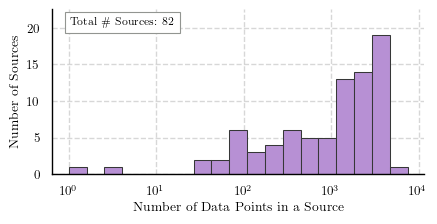

In [19]:
with plotting.paper_theme():
    plt.close()

    bar_colour = "xkcd:pale purple"
    line_colour = "xkcd:dark grey"

    fig, ax = plt.subplots(figsize=(colwidth, 0.5*colwidth))

    n_bins = 20

    logbins = np.geomspace(source_sizes.min(), source_sizes.max(), n_bins)

    ax.hist(
        source_sizes,
        color=bar_colour,
        bins=logbins,
        edgecolor=line_colour,
        linewidth=0.75,
    )

    ax.text(
        0.05,
        0.95,
        f"Total \# Sources: {len(source_sizes)}",
        fontsize=8,
        ha="left",
        va="top",
        transform=ax.transAxes,
        # nice box
        bbox=dict(facecolor="white", edgecolor="xkcd:grey"),
    )

    ax.set_xscale("log")

    ax.set_xlabel("Number of Data Points in a Source")
    ax.set_ylabel("Number of Sources")

    ax.set_ylim(0, 22.5)

    fig.subplots_adjust(top=0.98, bottom=0.2, left=0.1085, right=0.99)

    fig.savefig(output_path + "goemotions_source_sizes.pdf")

    plt.show()

In [20]:
source_labels = (
    pd.get_dummies(dataset.targets[train_dataset.indices])
    .assign(source=dataset.sources[train_dataset.indices])
    .groupby("source")
    .apply(lambda x: x.sum() / x.shape[0])
    .drop(columns="source")
)


# get columns with the three largest values in each row
source_frequent_labels = source_labels.apply(lambda x: x.nlargest(3).index.tolist(), axis=1)

# get the three largest values in each row
source_frequent_labels_size = source_labels.apply(lambda x: x.nlargest(3).values.tolist(), axis=1)

In [21]:
source_frequent_labels

source
0     [27, 18, 1]
1     [27, 18, 1]
2      [27, 0, 3]
3     [4, 27, 10]
4      [27, 4, 3]
         ...     
77     [27, 3, 1]
78     [27, 3, 0]
79     [22, 4, 0]
80     [27, 7, 0]
81     [27, 0, 6]
Length: 82, dtype: object

In [22]:
source_frequent_labels_size

source
0                       [0.4, 0.1, 0.06666666666666667]
1      [0.375, 0.11074561403508772, 0.0581140350877193]
2     [0.2387113140537798, 0.06265854895991882, 0.05...
3     [0.18565592374035406, 0.10848842487517023, 0.0...
4     [0.2865356331060302, 0.10736729509292686, 0.06...
                            ...                        
77    [0.20846905537459284, 0.19055374592833876, 0.0...
78    [0.29640947288006114, 0.09167303284950344, 0.0...
79    [0.18222222222222223, 0.17333333333333334, 0.1...
80    [0.2033898305084746, 0.11864406779661017, 0.08...
81    [0.3543970510795155, 0.10294892048446551, 0.07...
Length: 82, dtype: object

In [23]:
print(
    *(np.unique(dataset.targets, return_counts=True)[1]/len(dataset)*100).round(2), 
    sep="%, "
)

6.13%, 3.57%, 3.03%, 4.86%, 6.55%, 2.05%, 2.87%, 3.43%, 1.25%, 2.74%, 4.47%, 1.7%, 0.83%, 1.76%, 1.03%, 4.12%, 0.2%, 2.52%, 2.88%, 0.46%, 2.63%, 0.4%, 2.74%, 0.46%, 0.88%, 2.23%, 2.02%, 32.18


In [24]:
source_sizes = np.unique(dataset.sources, return_counts=True)[1]
print("mean", source_sizes.mean().round(2))
print("std", source_sizes.std().round(2))

mean 2095.37
std 1847.92


In [25]:
np.unique(
    dataset.targets, 
    return_counts=True
)[1]/len(dataset)*100

array([ 6.12908858,  3.56768711,  3.02758701,  4.8550809 ,  6.5527878 ,
        2.05040158,  2.87393784,  3.42509603,  1.2495635 ,  2.73891282,
        4.473286  ,  1.69596089,  0.83401234,  1.75765336,  1.03480386,
        4.11768129,  0.20428355,  2.51949715,  2.88499593,  0.46327552,
        2.63007799,  0.40158305,  2.74356885,  0.45861949,  0.87882668,
        2.22733093,  2.02071936, 32.1836806 ])

In [26]:
# what proportion of the data from each source is from each class

source_class_unique_number = []

for s in np.unique(dataset.sources):



    classes, class_sizes = np.unique(
            dataset.targets[dataset.sources == s], 
            return_counts=True
        )
    class_proportion = class_sizes / class_sizes.sum()

    source_size = class_sizes.sum()

    class_size_order = np.argsort(class_sizes)[::-1]
    classes = classes[class_size_order]
    class_sizes = class_sizes[class_size_order]
    class_proportion = class_proportion[class_size_order]

    source_class_unique_number.append(len(classes))

    classes_show = classes[:3]

    if s+1 in [1, 2, 4, 8, 16, 32, 64, 128]:

        print(
            f"\item Source {int(s)+1} " + "with size \\num{" f"{int(source_size)}" + "}:", 
            ", ".join([
                f'class {c+1} = ${s*100:.2f}\%$' 
                for c, s in zip(classes_show, class_proportion)
            ])
        )

\item Source 1 with size \num{37}: class 28 = $40.54\%$, class 19 = $8.11\%$, class 26 = $5.41\%$
\item Source 2 with size \num{1137}: class 28 = $38.43\%$, class 19 = $10.82\%$, class 2 = $5.89\%$
\item Source 4 with size \num{2702}: class 5 = $17.84\%$, class 28 = $11.84\%$, class 11 = $8.62\%$
\item Source 8 with size \num{1253}: class 28 = $14.45\%$, class 23 = $12.05\%$, class 21 = $10.45\%$
\item Source 16 with size \num{3224}: class 5 = $13.43\%$, class 23 = $12.38\%$, class 1 = $10.92\%$
\item Source 32 with size \num{175}: class 28 = $50.86\%$, class 8 = $18.86\%$, class 2 = $6.86\%$
\item Source 64 with size \num{623}: class 28 = $18.46\%$, class 4 = $11.88\%$, class 5 = $6.58\%$


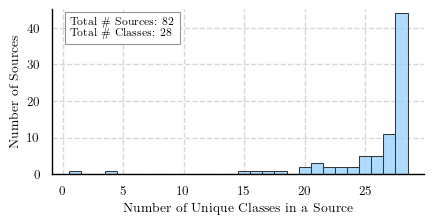

In [27]:
with plotting.paper_theme():
    plt.close()

    fig, ax = plt.subplots(figsize=(colwidth, 0.5*colwidth))

    bar_colour = "xkcd:light blue"
    line_colour = "xkcd:dark grey"

    ax = sns.histplot(
        source_class_unique_number,
        color=bar_colour,
        discrete=True,
        edgecolor=line_colour,
        linewidth=0.75,
        ax=ax,
    )

    ax.text(
        0.05,
        0.95,
        f"Total \# Sources: {len(source_sizes)}\nTotal \# Classes: {len(np.unique(dataset.targets))}",
        fontsize=8,
        ha="left",
        va="top",
        transform=ax.transAxes,
        # nice box
        bbox=dict(facecolor="white", edgecolor="xkcd:grey"),
    )

    ax.set_xlabel("Number of Unique Classes in a Source")
    ax.set_ylabel("Number of Sources")

    ax.set_ylim(0, 45)

    fig.subplots_adjust(top=0.98, bottom=0.2, left=0.1085, right=0.99)

    fig.savefig(output_path + "goemotions_source_class_unique_number.pdf")

    plt.show()